In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import numpy.ma as ma
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
from analysis_tools import getobjdata

import scipy.ndimage as ndimage
import matplotlib.colors as mcolors

from colormaps import radar_colormap

#from Plot_tools import *
from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

from tools.cbook import pickle2Obj

_nthreads = 2

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

savePlots = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
wrf_dir  = '/work/wicker/climate_runs/WRF/WRF_v4.4.2/ideal/base'
cm1_dir  = '/work/wicker/climate_runs/cm1r20.3/run/base'
mpas_dir = '/work/wicker/climate_runs/MPAS/squall/base/'

models1 = {}
models2 = {}

models1['wrf']    = pickle2Obj(os.path.join(wrf_dir, 'precip.pkl'),retObj=False)
# models['wrf-4']    = pickle2Obj(os.path.join(wrf_dir, '4th/precip.pkl'),retObj=False)
models1['cm1']    = pickle2Obj(os.path.join(cm1_dir, 'precip.pkl'),retObj=False)
# models['cm1-4']    = pickle2Obj(os.path.join(cm1_dir, '4th/precip.pkl'),retObj=False)
models1['mpas']   = pickle2Obj(os.path.join(mpas_dir, 'precip.pkl'),retObj=False)



#models['wrfTM']  = pickle2Obj('climate_runs/profiles/wrf_squall_3km_thetaM.pkl',retObj=False)


In [13]:
models1['mpas-wofs']   = pickle2Obj(os.path.join(mpas_dir, 'wofs/precip.pkl'),retObj=False)


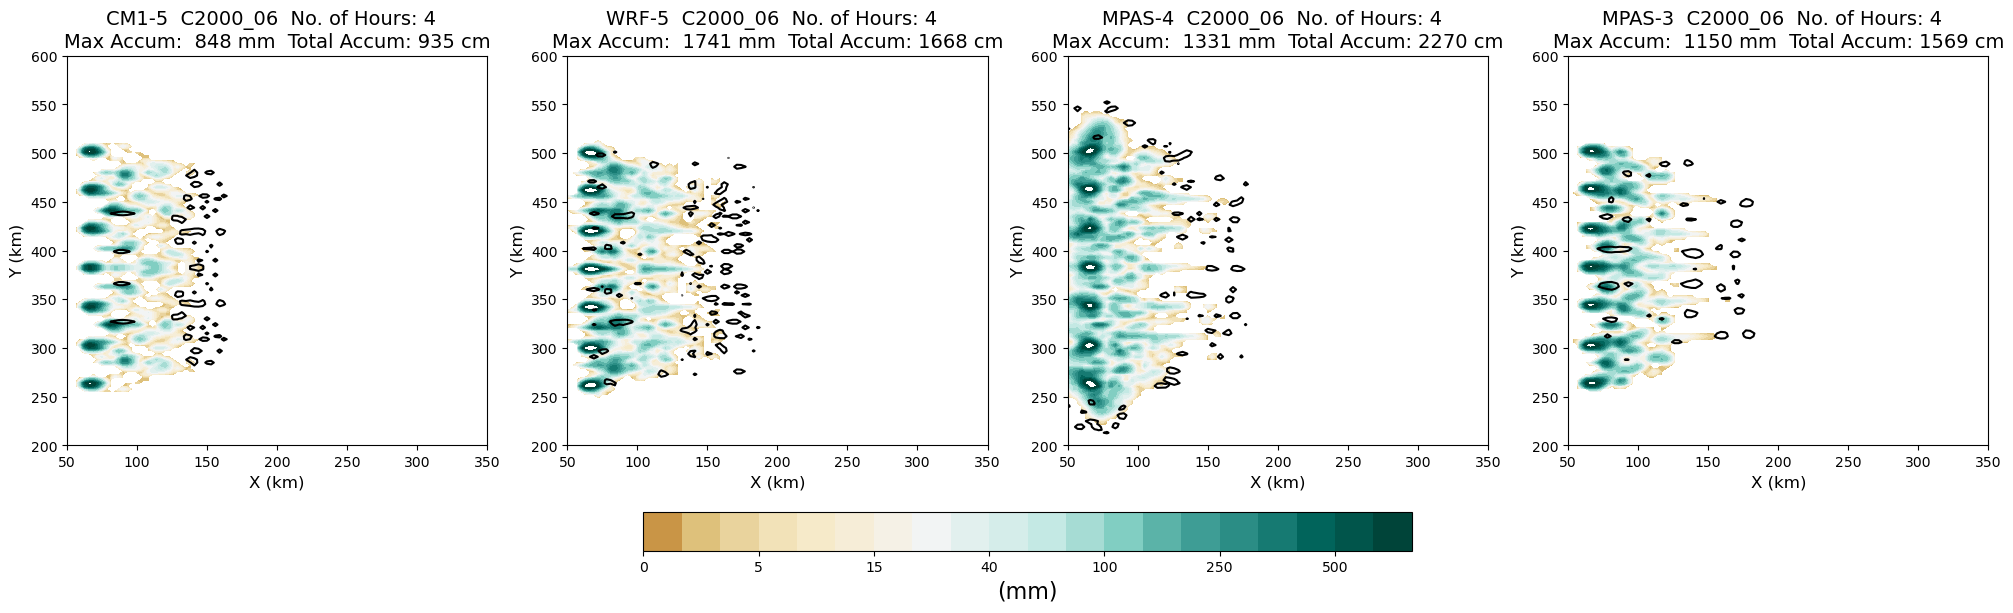

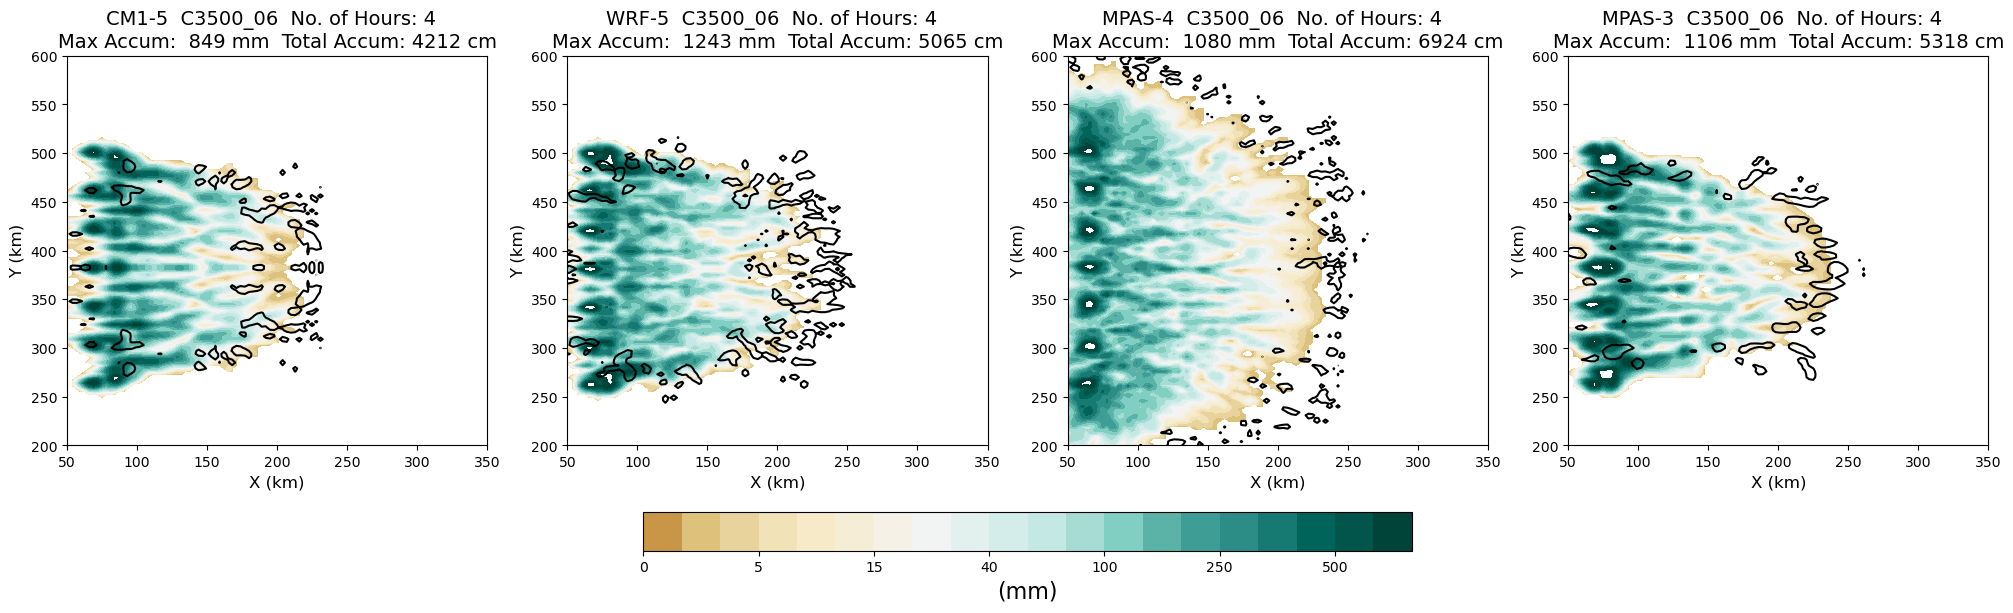

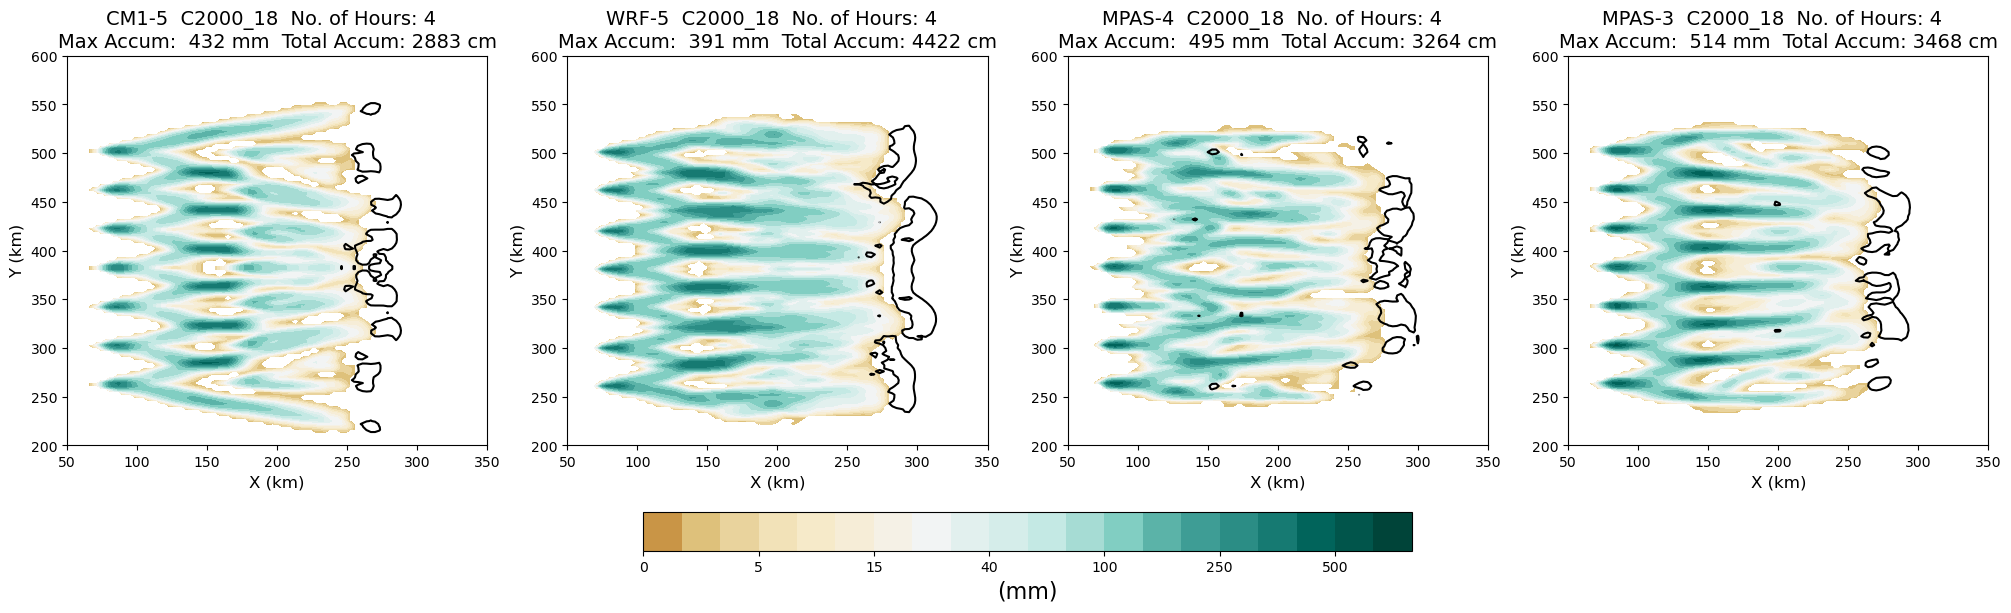

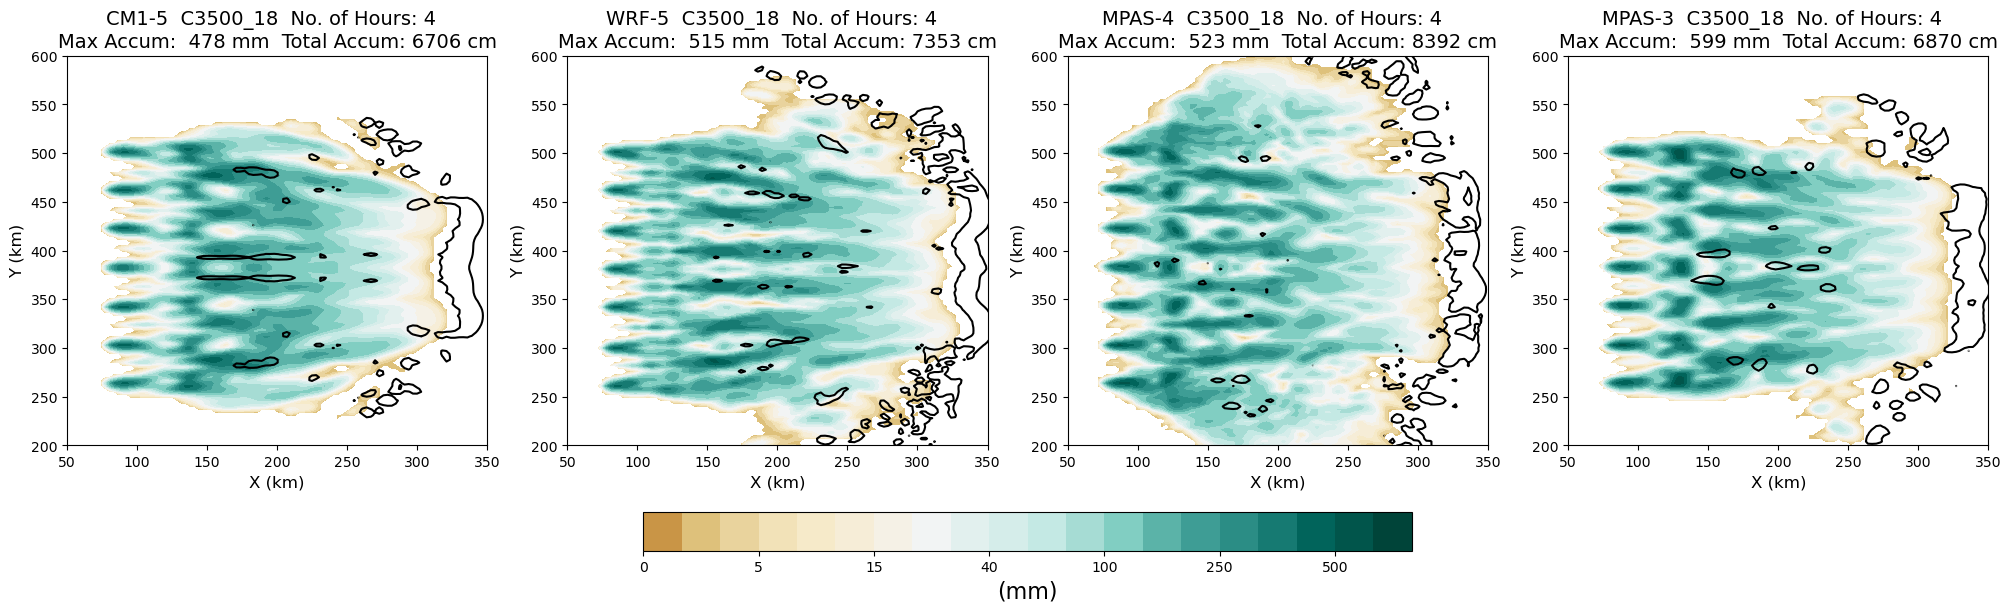

In [15]:
def plot_interval_precip(models, key, label, start, end=16, clevels=[100,300,500], ax=None):
   
    fld      = models[key][label]['accum_prec'][start:start+end].sum(axis=0)
    fld_mask = np.where(fld > 1.0, fld, np.nan)
    pmax     = fld.max()
    ptotal   = fld.sum()

    wmax = models[key][label]['wmax'][start+end]
        
    xg = 3*np.arange(models[key][label]['accum_prec'].shape[2])    
    yg = 3*np.arange(models[key][label]['accum_prec'].shape[1])
    
    cs = ax.contourf(xg, yg, fld_mask, clevs, cmap=plt.cm.get_cmap('BrBG'), norm=mlab.colors.PowerNorm(gamma=0.2))
    cs2 = ax.contour(xg, yg, wmax, levels = [5.0,], colors= 'k')
    # cs = ax.contourf(xg, yg, fld_mask, clevs, cmap=cmap, norm=mlab.colors.PowerNorm(gamma=.5))

    ax.set_ylabel('Y (km)', fontsize=12)
    ax.set_xlabel('X (km)', fontsize=12)
    ax.set_title("%s  %s  No. of Hours: %d  \nMax Accum:  %d mm  Total Accum: %d cm" % (key.swapcase(), label, int(start+end)/4, 
                                                                                int(pmax), int(ptotal//100)), fontsize=14)
    ax.set_xlim(50., 350.)
    ax.set_ylim(200.0, 600.)
    
    return cs
    
#-----------------------------
allcape = ("C2000","C3500",)
allshear = ("06", "18")

start = 0

for shear in allshear:
    for cape in allcape:

        fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(20,6))
        
        label = "%s_%s" % (cape, shear)

        cs = plot_interval_precip(models1, 'wrf-5', label, start=start, ax=ax[1])
        cs = plot_interval_precip(models1, 'cm1-5', label, start=start, ax=ax[0])

        # cs = plot_interval_precip(models, 'wrf-4', label, start=start, end=end, ax=ax[1])
        cs = plot_interval_precip(models1, 'mpas-4', label, start=start, ax=ax[2])
        cs = plot_interval_precip(models1, 'mpas-3', label, start=start, ax=ax[3])
        
        cbar = fig.colorbar(cs, ax=ax[:], shrink=0.4, location='bottom')
        cbar.set_label('(mm)', fontsize=16)
        
        if savePlots:  plt.savefig("Experiment_%s_HourlyPrecipAccum_Hour%d.png" % (label, int(start+4)/4))

In [4]:
# draw filled contours.
clevs = np.asarray([0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750])

cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(0.5*clevs, cmap.N)

def plot_hovmoller_precip(models, key, label,clevels=[10,30,50], ylim = None, ax=None):
    
    # Arbitrary weights
    # weights = np.array([[0, 0, 1, 0, 0],
    #                     [0, 2, 4, 2, 0],
    #                     [1, 4, 8, 4, 1],
    #                     [0, 2, 4, 2, 0],
    #                     [0, 0, 1, 0, 0]], dtype=np.float)
    # weights = weights / np.sum(weights[:])
    
    # fmean = ndimage.filters.convolve(models[key][label]['accum_prec'].mean(axis=1),  weights, mode='constant')
    # fmax  = ndimage.filters.convolve(models[key][label]['accum_prec'].max(axis=1),  weights, mode='constant')
    
    # first, compute the increments in time of precip
    
    inv = models[key][label]['accum_prec'][::-1]
    fld       = np.zeros_like(inv)
    precip    = np.ma.zeros_like(inv)
    fld[1:,:] = (inv[0:-1] - inv[1:])[::-1]
    
    # fld      = models[key][label]['accum_prec']
    fld_mask = np.where(fld > 0.1, fld, np.nan)
    fmean    = np.nanmean(fld_mask, axis=1)
    fmax     = fld.mean()
    
    if key == 'solo':
        time = 15. + 15*np.arange(models[key][label]['accum_prec'].shape[0])
    else:
        time = 15*np.arange(models[key][label]['accum_prec'].shape[0])
        
    xg = 3*np.arange(models[key][label]['accum_prec'].shape[2])
    
    cs = ax.contourf(xg, time[::-1], fmean[::-1], clevs, cmap=cmap, norm=norm)
    
    # ax.contour(xg, time, fmax, clevels=clevels, colors=['k','r','b'])
    ax.set_ylabel('Time (min)', fontsize=12)
    ax.set_xlabel('X (km)', fontsize=12)
    ax.set_title("Hovmoller for %s  %s   \n  15 Min Max Accum:  %2.0f mm" % (key.swapcase(), label, np.nanmax(fmean)), fontsize=16)
    ax.set_xlim(0.0, 600)
    if ylim:
        ax.set_ylim(ylim,0.0)
    else:
        ax.set_ylim(time[-1],0.0)
    
    return cs
    

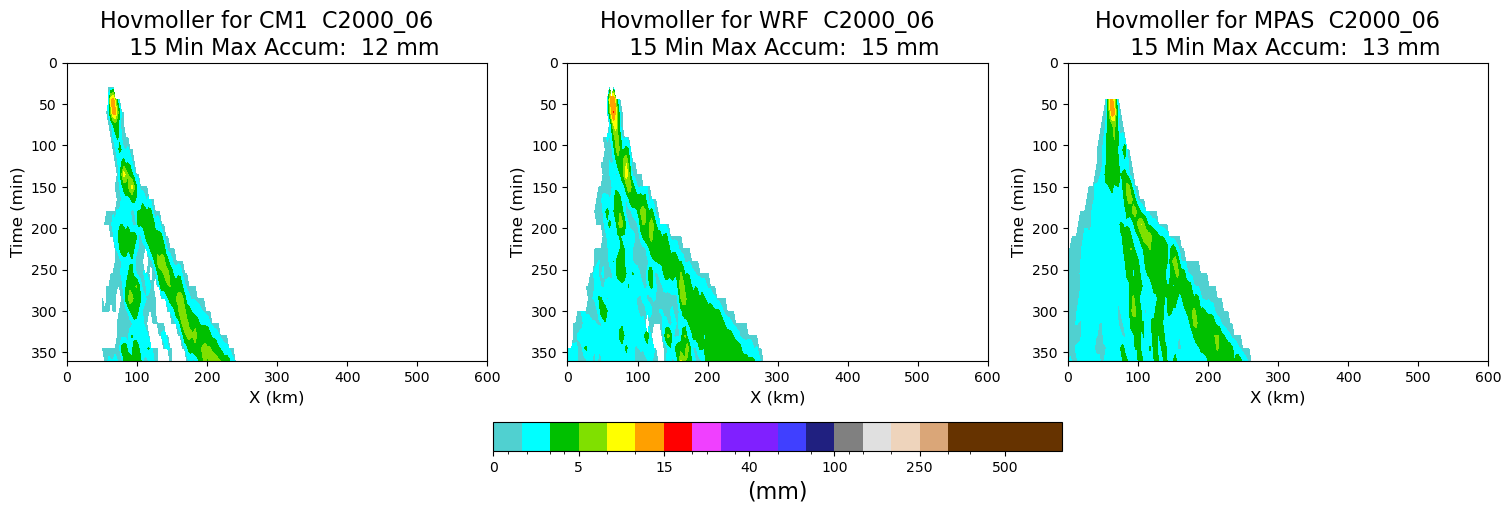

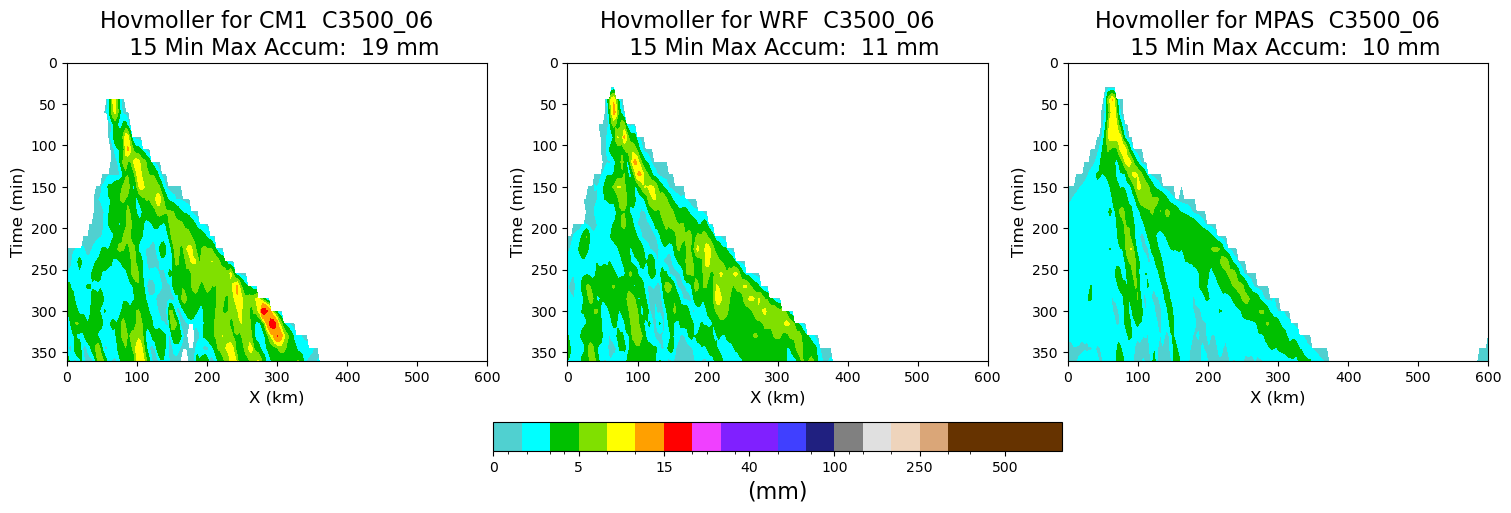

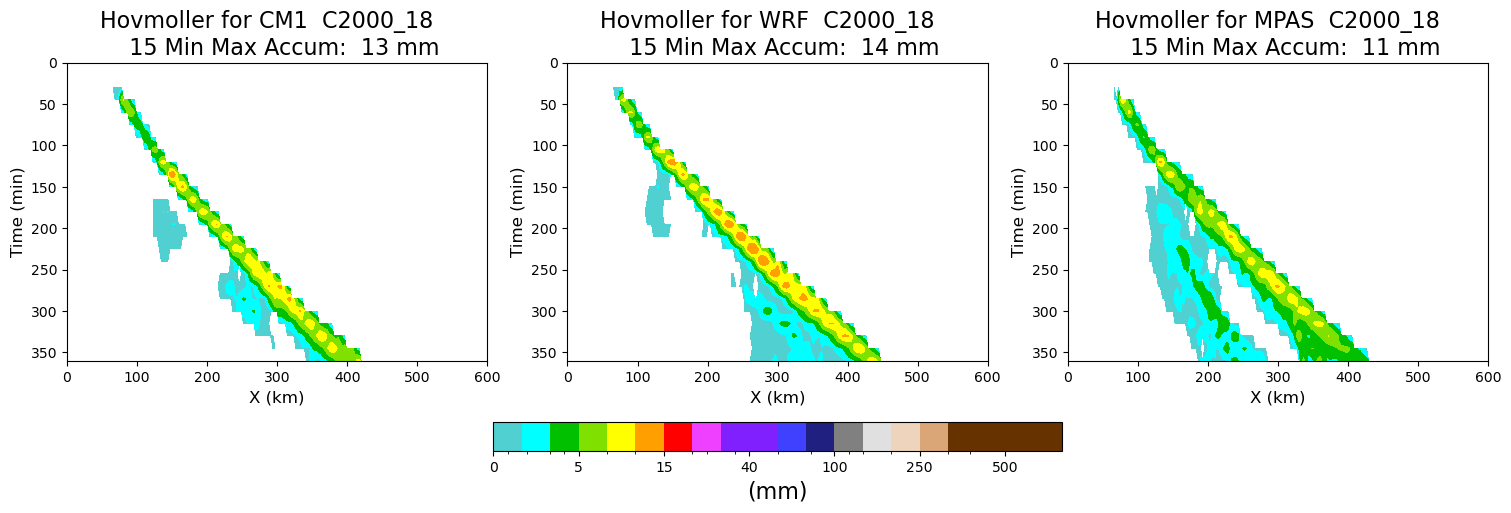

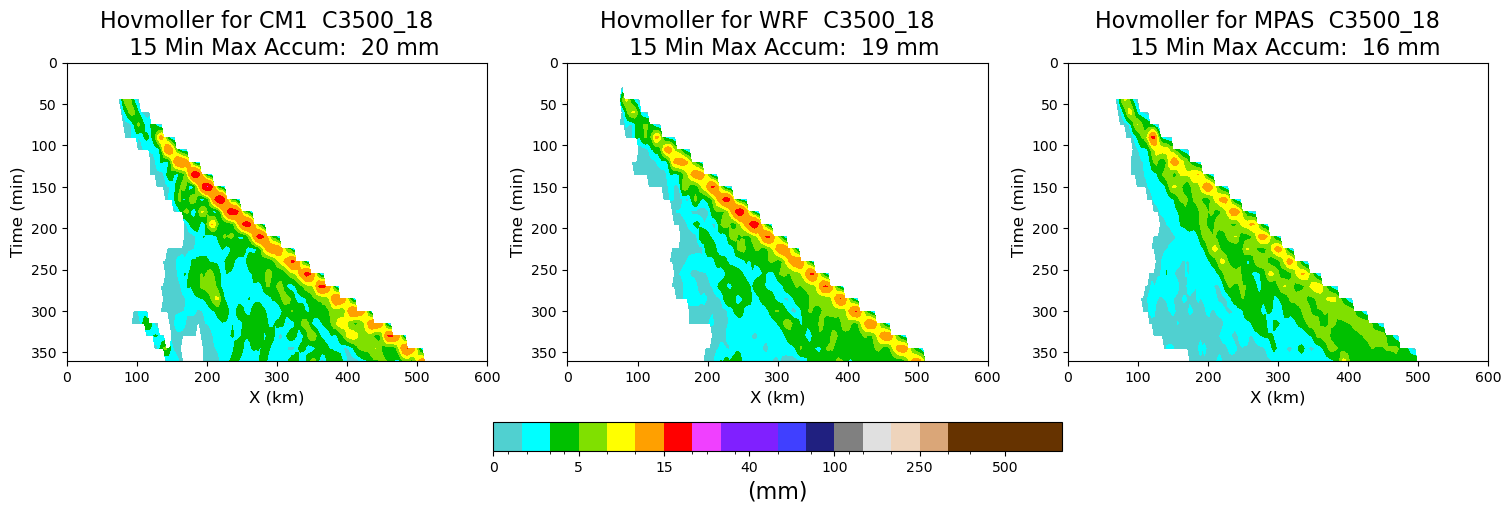

In [8]:
#-----------------------------
allcape = ("C2000","C3500",)
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:

        fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))
        
        label = "%s_%s" % (cape, shear)
        
        cs = plot_hovmoller_precip(models1, 'cm1', label, ax=ax[0])
        cs = plot_hovmoller_precip(models1, 'wrf', label, ax=ax[1]) 
        cs = plot_hovmoller_precip(models1, 'mpas', label, ax=ax[2])
#        cs = plot_hovmoller_precip(models, 'mpas3', label, ax=ax[3])
        
        cbar = fig.colorbar(cs, ax=ax[:], shrink=0.4, location='bottom')
        cbar.set_label('(mm)', fontsize=16)
        
        plt.savefig("Experiment_%s_Hovmoller.png" % (label))

In [8]:
models = { 'cm1': pickle2Obj('precip/cm1_squall_1km_accum_prec.pkl',retObj=False),
           'wrf': pickle2Obj('precip/wrf_squall_1km_accum_prec.pkl', retObj=False),
           'solo': pickle2Obj('precip/solo_squall_1km_accum_prec.pkl',retObj=False),
           # 'solo2': pickle2Obj('precip/solo_squall_3km_nord2_accum_prec.pkl',retObj=False),
           # 'solo1': pickle2Obj('precip/solo_squall_3km_nord1_accum_prec.pkl',retObj=False) 
         }

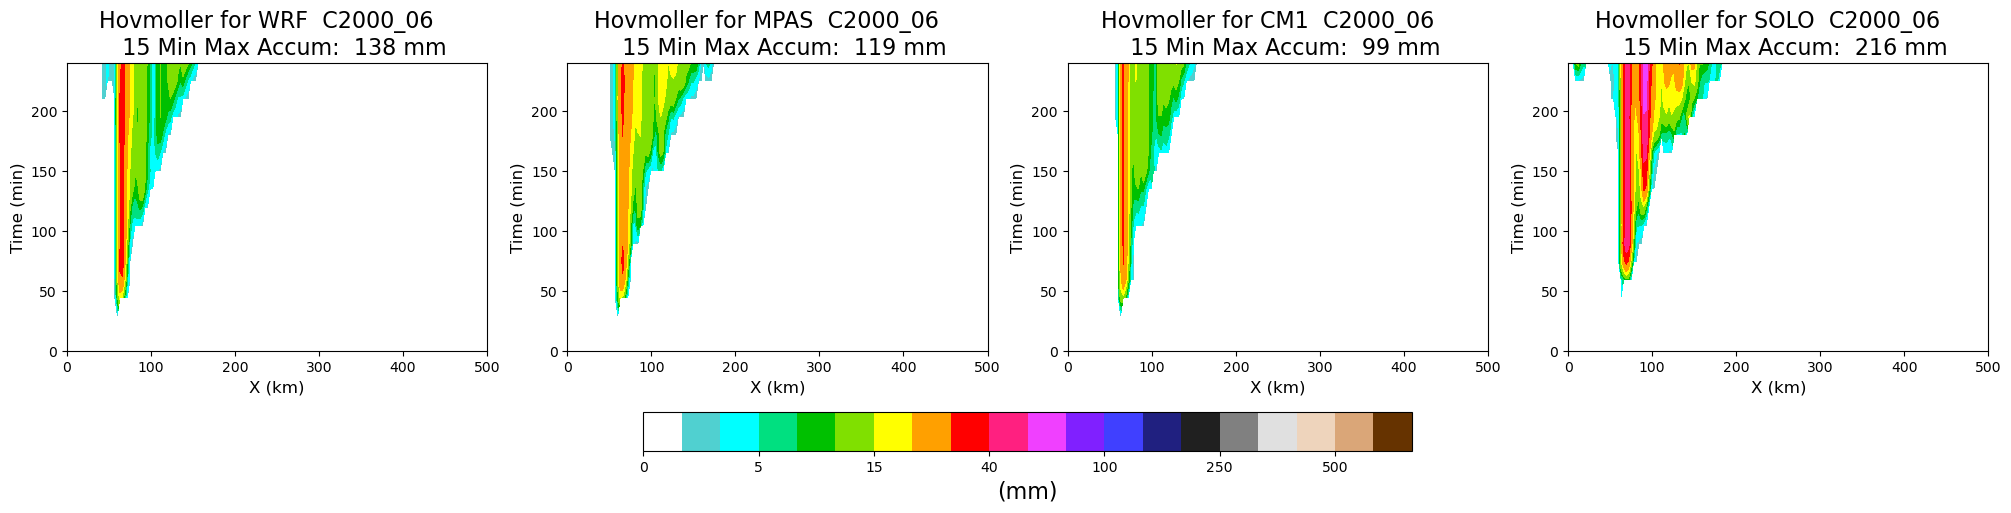

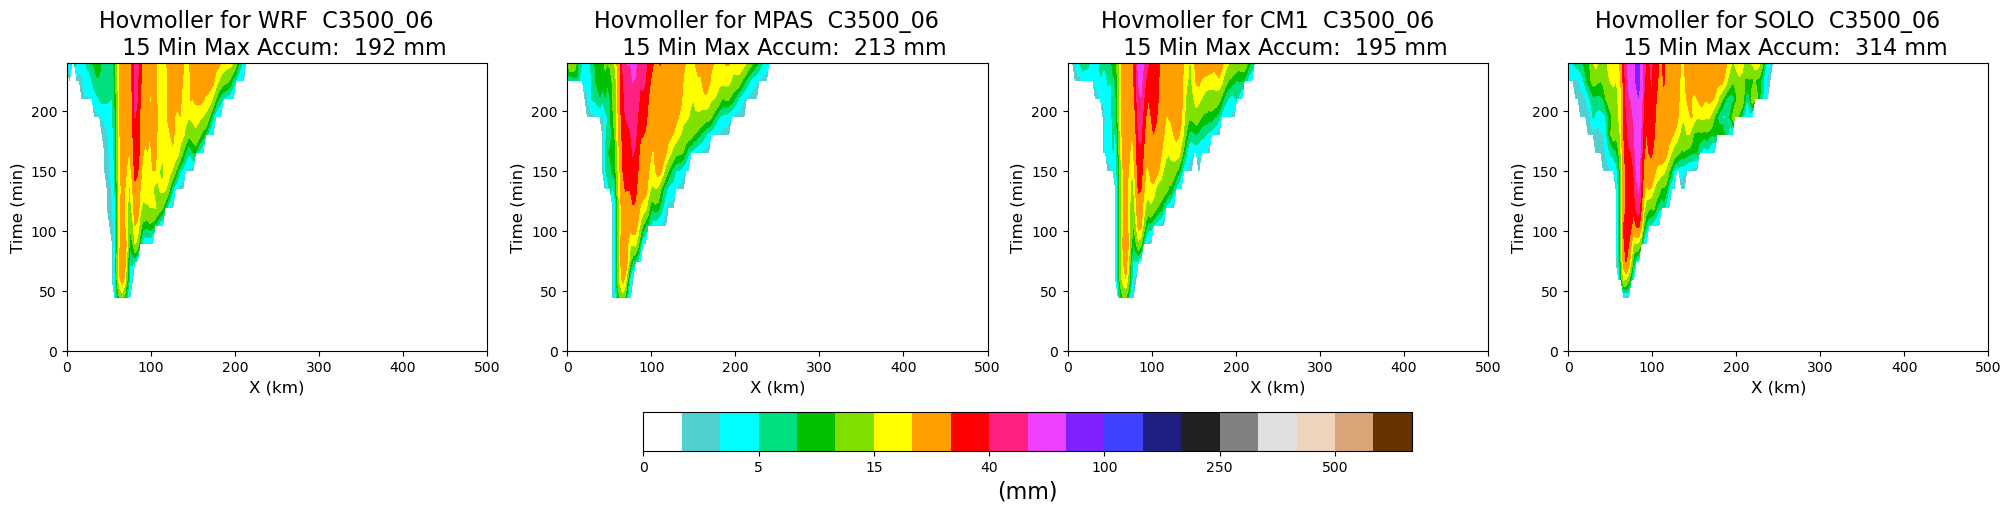

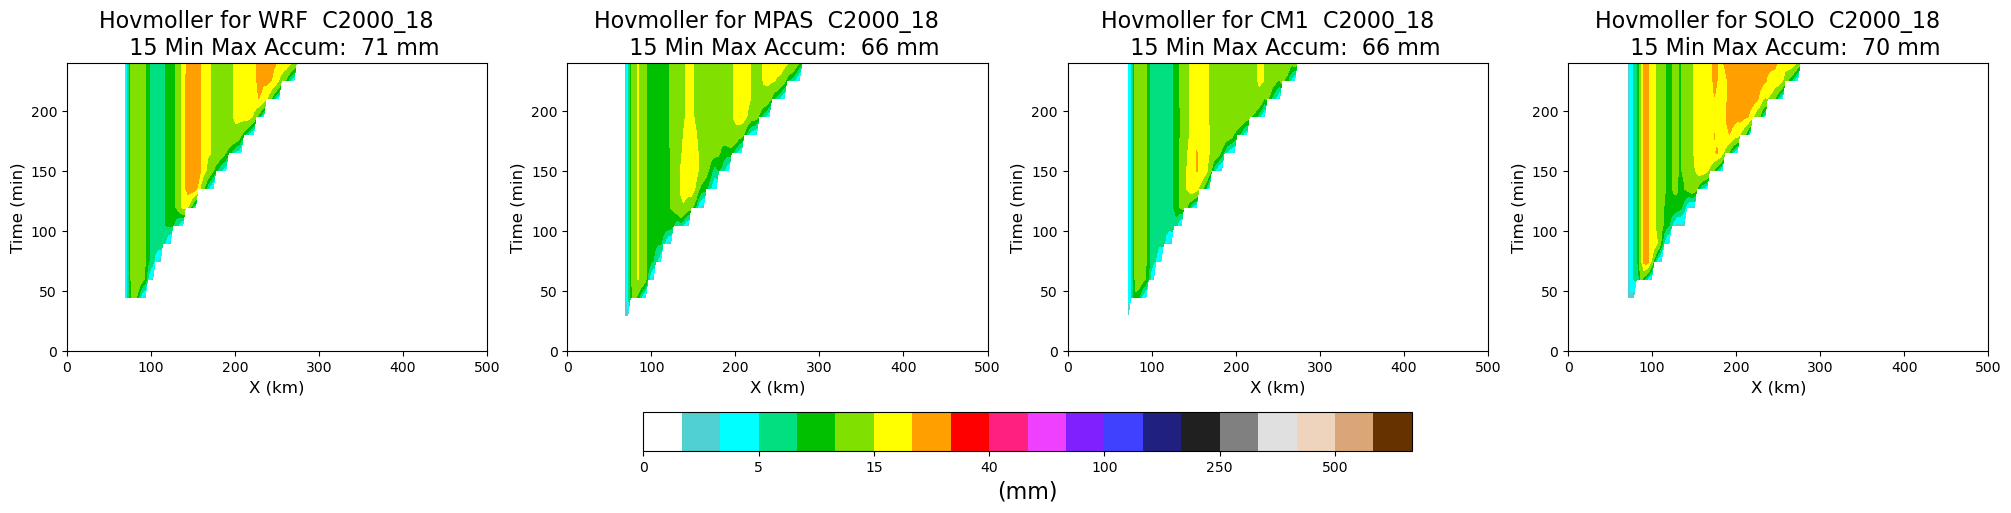

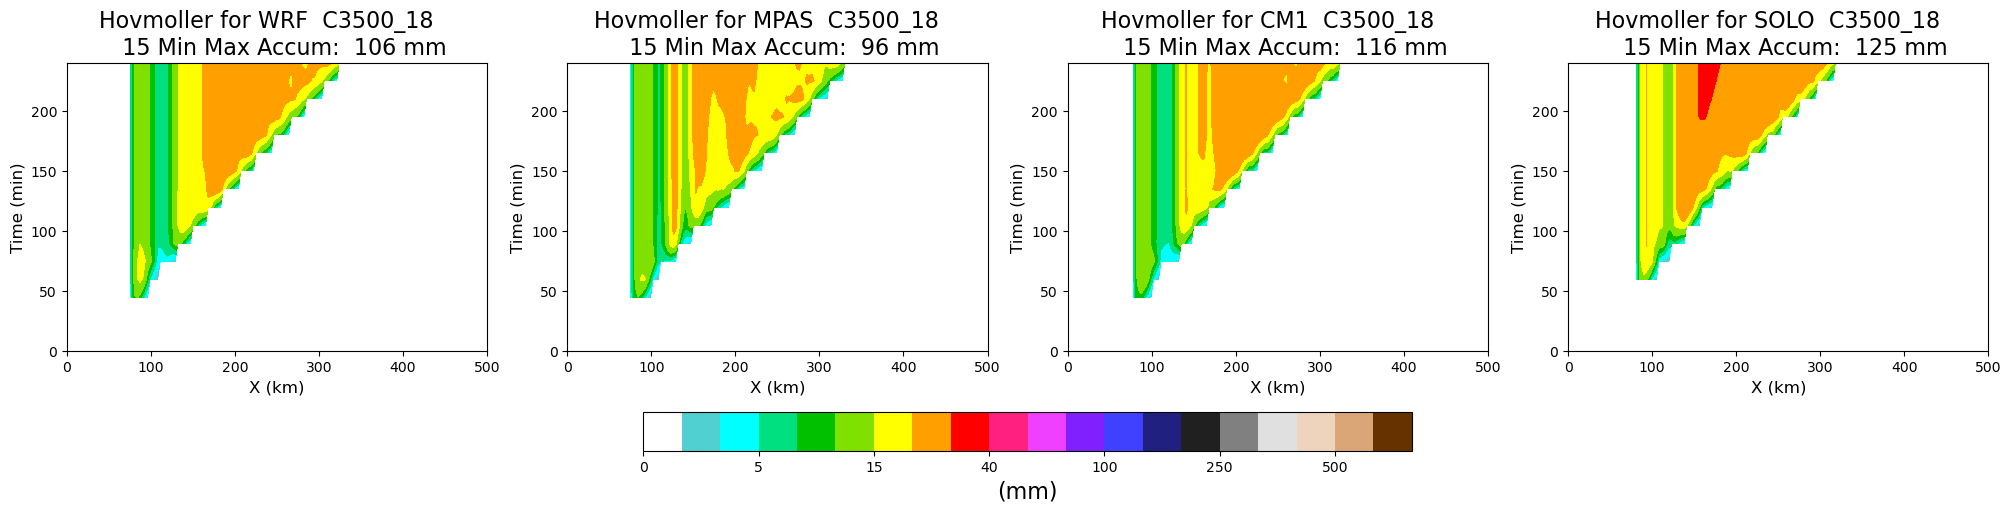

In [7]:
#-----------------------------
allcape = ("C2000","C3500",)
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:

        fig, ax = plt.subplots(1,4, constrained_layout=True, figsize=(20,5))
        
        label = "%s_%s" % (cape, shear)
        
        cs = plot_hovmoller_precip(models, 'wrf', label, ax=ax[0], ylim = 240.)
        cs = plot_hovmoller_precip(models, 'mpas', label, ax=ax[1], ylim = 240.)

        
        cs = plot_hovmoller_precip(models, 'cm1', label, ax=ax[2], ylim = 240.) 
        cs = plot_hovmoller_precip(models, 'solo', label, ax=ax[3], ylim = 240.) 
         
        
        cbar = fig.colorbar(cs, ax=ax[:], shrink=0.4, location='bottom')
        cbar.set_label('(mm)', fontsize=16)
        
        plt.savefig("Experiment_1km_%s_Hovmoller.png" % (label))